In [22]:
import pandas as pd
import plotnine as pn

df_0 = pd.read_csv("output/k562_memory_bench/k562_memory_results.csv")
df_0["dataset"] = "k562"

df_1 = pd.read_csv("output/hct116_memory_bench/hct116_memory_results.csv")
df_1["dataset"] = "hct116"

df_2 = pd.read_csv("output/hek293t_memory_bench/hek293t_memory_results.csv")
df_2["dataset"] = "hek293t"

df = pd.concat([df_0, df_1, df_2])
df["coreset_fraction"] = pd.Categorical(df["coreset_fraction"])

coreset_colors = {
    1.0: "#a24343",
    0.1: "#96b728",
}
df.head()

,n_archetypes,n_cells,coreset_fraction,seed,ok,error,rss_poll_ms,time,time_total,time_copy,...,mem_rss_post_copy_mb,mem_rss_end_mb,mem_rss_delta_post_copy_mb,mem_rss_delta_since_start_mb,mem_rss_peak_mb,mem_rss_peak_over_post_copy_mb,mem_rss_peak_over_start_mb,mem_rss_peak_copy_sampled_mb,mem_rss_peak_compute_sampled_mb,dataset
0,3,1000,1.0,383329927,True,NaN,50,2.430400,2.491858,0.060645,...,37208.960938,37210.199219,1.238281,0.109375,37210.875000,0.0,0.785156,37210.242188,37210.121094,k562
1,3,1000,1.0,3324115916,True,NaN,50,2.450171,2.517651,0.066318,...,37208.960938,37210.140625,1.179688,0.050781,37210.875000,0.0,0.785156,37210.242188,37210.105469,k562
2,3,1000,1.0,2811363264,True,NaN,50,2.299523,2.354797,0.054427,...,37208.960938,37210.152344,1.191406,0.062500,37210.875000,0.0,0.785156,37210.242188,37210.109375,k562
3,3,1000,1.0,1884968544,True,NaN,50,2.229405,2.289329,0.059096,...,37208.960938,37210.148438,1.187500,0.058594,37210.875000,0.0,0.785156,37210.429688,37210.113281,k562
4,3,1000,1.0,1859786275,True,NaN,50,2.487568,2.542126,0.053645,...,37208.964844,37210.152344,1.187500,0.058594,37210.878906,0.0,0.785156,37210.246094,37210.101562,k562


/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


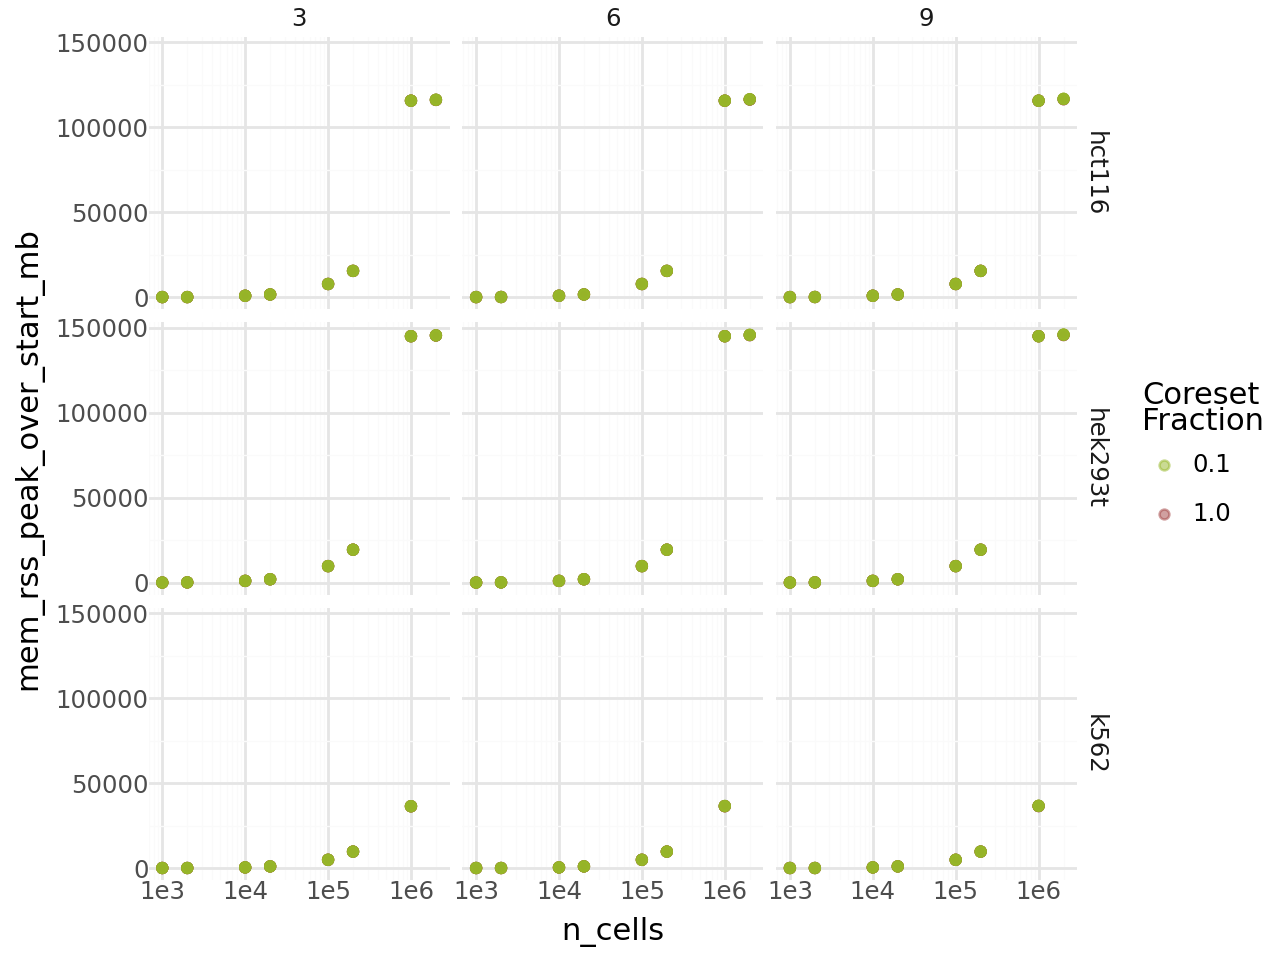

In [23]:
p = (
    pn.ggplot(df)
    + pn.geom_point(
        pn.aes(x="n_cells", y="mem_rss_peak_over_start_mb", color="coreset_fraction"),
        alpha=0.5
    )
    + pn.facet_grid(rows="dataset", cols="n_archetypes")
    + pn.scale_x_log10()
    + pn.scale_color_manual(values=coreset_colors, name="Coreset\nFraction")
    + pn.theme_minimal()
)
p.show()

/home/pschaefer/miniforge3/envs/partipy/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


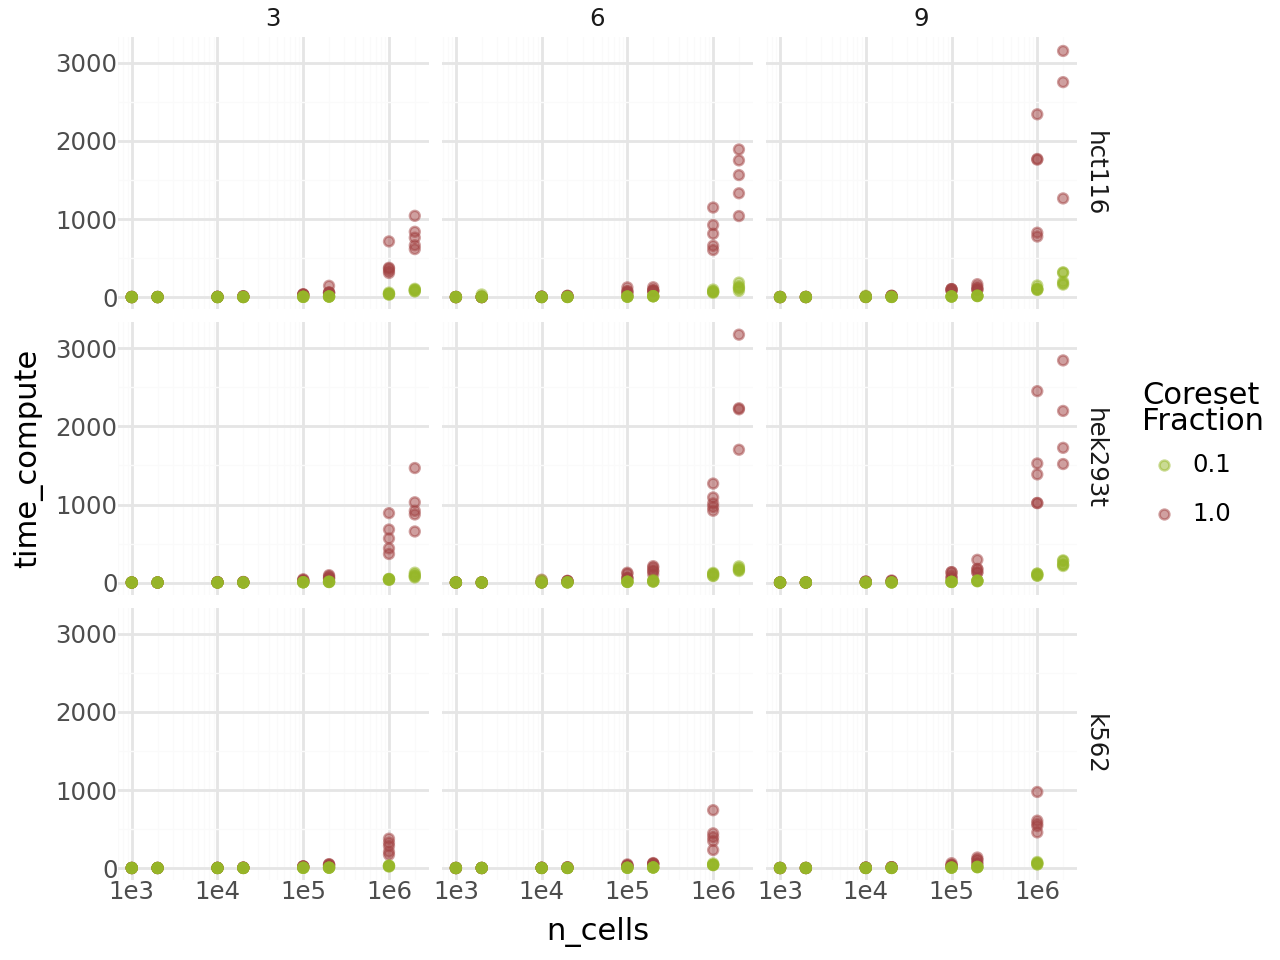

In [24]:
p = (
    pn.ggplot(df)
    + pn.geom_point(
        pn.aes(x="n_cells", y="time_compute", color="coreset_fraction"),
        alpha=0.5
    )
    + pn.facet_grid(rows="dataset", cols="n_archetypes")
    + pn.scale_x_log10()
    + pn.scale_color_manual(values=coreset_colors, name="Coreset\nFraction")
    + pn.theme_minimal()
)
p.show()